In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
pd.set_option("display.max_columns",999)
import numpy as np
import json

# Getting some info from JSON file

In [2]:
df = pd.read_pickle("./cuentalo_json_to.pkl")

# Vamos a geolocalizar tweets

In [3]:
# Cuan malo es el problema?
print("con lat-lon",len(df[df.lon>-500]))
print("con pais",len(df[(df.country.notnull())]))
print("con location",len(df[(df.location!="")&(df.location!="\t")&(df.location!="\n")]))


con lat-lon 18
con pais 5269
con location 1456565


In [4]:
a=df.groupby('location').count()[['id']]

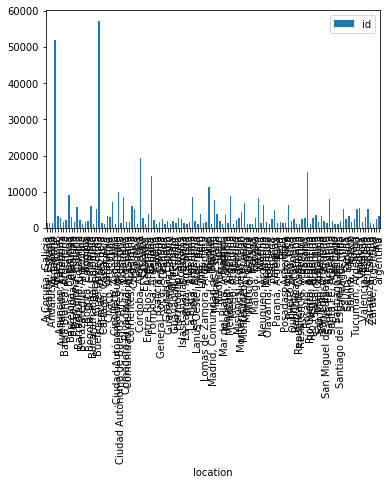

In [5]:
a[(a.id>1000)&(a.id<100000)].plot.bar()

In [6]:
df.country.dropna().unique()

array(['Spain', 'Argentina', 'France', 'Germany', 'Switzerland', 'Panama',
       'Chile', 'United Kingdom', 'Peru', 'Portugal', 'Belgium',
       'Ecuador', 'Costa Rica', 'The Netherlands', 'Andorra', 'Uruguay',
       'Mexico', 'Colombia', 'Turkey', 'Italy', 'Venezuela', 'Poland',
       'Denmark', 'Bolivia', 'Sweden', 'Ireland', '', 'Thailand',
       'Nigeria', 'United States', 'Indonesia', 'Australia', 'Bangladesh',
       'Cuba', 'Lebanon', 'Honduras', 'Paraguay', 'Guatemala', 'Brazil',
       'Nicaragua', 'Russia', 'Jamaica', 'Finland', 'El Salvador',
       'Austria', 'Canada', 'Dominican Republic', 'New Zealand', 'India',
       'Hungary', 'Norway', 'Saint Kitts and Nevis'], dtype=object)

In [7]:
df.place.unique()

array([None, 'Madrid, Spain', 'Barcelona, Spain', ...,
       'Puerto General San Martin, Argentina', 'Curacautín, Chile',
       'Böblingen, Germany'], dtype=object)

In [128]:
# attempt 1: From the data
# 
# leer paises y ciudades...
# attempt 2: 
# https://arxiv.org/pdf/1403.2345.pdf
# la proxima vez...

### Bajamos paises y ciudades
World countries: https://github.com/stefangabos/world_countries

Cities: http://www.unece.org/cefact/codesfortrade/codes_index.html, http://download.geonames.org/export/dump/


get unlocode from this: https://datahub.io/core/un-locode

In [5]:
from country_city_sets import *

#### Ahora el codigo para identificar pais/ciudad

In [6]:
from utils import *

In [7]:
l='Baker Street, London.'
cl=clean_string(l)
p=find_ngrams(cl.split())
p

['baker',
 'street',
 'london',
 'baker street',
 'street london',
 'baker street london']

In [8]:
check_substring(l,cities_set)

['london']

In [9]:
check_substring('Unquillo',cities_set)

['unquillo']

In [10]:
[country_from_code[c] for c in country_of_city['london']]

['united kingdom of great britain and northern ireland']

In [11]:
import itertools

In [12]:
## AHORA SI LA FUNCION PRINCIPAL
def localize_tweet(row):
    country_raw=row['country']
    place_raw=row['place']
    location_raw=row['location']
    tz=row['time_zone']
    if location_raw==None or location_raw=="":
        if tz in specific_tz:
            return 1, (None,specific_tz[tz],tz) #sin info, sacado del time_zone
        return -1, (None,None,None) #sin info, texto vacio
    # clean location_raw
    location=clean_string(location_raw)
    # try to find country in location
    mentioned_countries=check_substring(location,country_set)
    # sacamos Granada a la mierda
    if 'granada' in mentioned_countries:
        mentioned_countries.remove('granada')
    # try to find city in location
    mentioned_cities=check_substring(location,cities_set)
    # try to find city in region
    mentioned_regions=check_substring(location,regiones.keys())    
    ###
    ## casos 
    ## city 0, country 0: region?
    if len(mentioned_countries)==0 and len(mentioned_cities)==0:
        if len(mentioned_regions)>0:
            return 2, (None, country_from_code[regiones[mentioned_regions[0]]],tz) #solo se menciona una region
        else:
            return -2, (None, None,tz) #no se menciona nada conocido
    ## city 0, country 1: return country
    elif len(mentioned_countries)==1 and len(mentioned_cities)==0:
        return 3, (None, mentioned_countries[0],tz)  #solo se menciona un pais  
    ## city 0, country >1: region o jerarquia?
    elif len(mentioned_countries)>1 and len(mentioned_cities)==0:
        return 3.5, (None, mentioned_countries[0],tz)  #varios paises, nos quedamos con el primero?    
    ## city 1, country 0: country from region or city
    elif len(mentioned_countries)==0 and len(mentioned_cities)==1:
        # query region
        if len(mentioned_regions)>0:
            bump = 0 if regiones[mentioned_regions[0]] in country_of_city[mentioned_cities[0]] else 0.001
            return 4+bump, (mentioned_cities[0], country_from_code[regiones[mentioned_regions[0]]],tz) #se menciona una ciudad y una region
        if mentioned_cities[0] in country_of_city:
            possible_countries=[country_from_code[x] for x in country_of_city[mentioned_cities[0]]]
        else:
            possible_countries = []
        if len(possible_countries)==1:
            bump = 0 if code_of_country[possible_countries[0]] in country_of_city[mentioned_cities[0]] else 0.001
            return 5+bump,(mentioned_cities[0], possible_countries[0],tz) #se menciona ciudad, de alli se deduce el pais
        elif len(possible_countries)==0:
            if tz in specific_tz:
                bump = 0 if code_of_country[specific_tz[tz]] in country_of_city[mentioned_cities[0]] else 0.001
                return 6+bump, (mentioned_cities[0],specific_tz[tz],tz) #se menciona ciudad, del tz se deduce pais
            else:
                return 7, (mentioned_cities[0], None,tz) #se menciona ciudad pero no sabemos pais
        else: 
            ###### one city, many countries -- criteria?
            # time zone
            if tz in specific_tz and specific_tz[tz] in possible_countries:
                bump = 0 if code_of_country[specific_tz[tz]] in country_of_city[mentioned_cities[0]] else 0.001
                return 8+bump, (mentioned_cities[0],specific_tz[tz],tz) #se menciona ciudad pero desempatamos pais con el tz
            # priorities? doesn´t work for latin america...?
            if 'spain' in possible_countries:
                bump = 0 if code_of_country['spain'] in country_of_city[mentioned_cities[0]] else 0.001
                return 9+bump, (mentioned_cities[0],'spain',tz) #se menciona ciudad pero pueden ser varios paises, se asume españa
            elif 'united kingdom' in possible_countries:
                bump = 0 if code_of_country['united kingdom'] in country_of_city[mentioned_cities[0]] else 0.001
                return 10+bump, (mentioned_cities[0],'united kingdom',tz)#se menciona ciudad pero pueden ser varios paises, se asume UK         
            # set theory
            set_cit=set(possible_countries)
            if len(set_cit)==1:
                bump = 0 if code_of_country[list(set_cit)[0]] in country_of_city[mentioned_cities[0]] else 0.001
                return 11+bump, (mentioned_cities[0],list(set_cit)[0],tz) #se menciona ciudad y el mismo pais varias veces
            else:
                return -3,(mentioned_cities,possible_countries,tz)  #se menciona ciudad y no podemos discriminar entre varios posibles paises  
    ## city 1, country 1: return
    elif len(mentioned_countries)==1 and len(mentioned_cities)==1:
        bump = 0 if code_of_country[mentioned_countries[0]] in country_of_city[mentioned_cities[0]] else 0.001
        return 12+bump, (mentioned_cities[0], mentioned_countries[0],tz) #se menciona una ciudad y un pais
    ## city 1, country >1: country from city
    elif len(mentioned_countries)>1 and len(mentioned_cities)==1:
        possible_countries=[country_from_code[x] for x in country_of_city[mentioned_cities[0]]] if mentioned_cities[0] in country_of_city else []
        if tz in specific_tz and specific_tz[tz] in possible_countries:
            bump = 0 if code_of_country[specific_tz[tz]] in country_of_city[mentioned_cities[0]] else 0.001
            return 13+bump, (mentioned_cities[0],specific_tz[tz],tz) #se menciona ciudad, desempatamos pais con tz
        # set theory, popular vote or intersections
        set_loc=set(mentioned_countries)
        set_cit=set(possible_countries)
        intersect=set_loc.intersection(set_cit)
        if len(intersect)==1:
            bump = 0 if code_of_country[list(intersect)[0]] in country_of_city[mentioned_cities[0]] else 0.001
            return 14+bump, (mentioned_cities[0],list(intersect)[0],tz) #se menciona una ciudad y varios paises, desempatamos mirando a que pais corresponde la ciudad   
        # priorities? doesn´t work for latin america...
        all_countries = mentioned_countries+possible_countries
        if 'spain' in all_countries or 'espana' in all_countries: #se menciona una ciudad y muchos paises, si está se asume españa (1ero)
            bump = 0 if code_of_country['spain'] in country_of_city[mentioned_cities[0]] else 0.001
            return 15+bump, (mentioned_cities[0],'spain',tz)
        elif 'united kingdom' in all_countries:
            bump = 0 if code_of_country['united kingdom'] in country_of_city[mentioned_cities[0]] else 0.001
            return 16+bump, (mentioned_cities[0],'united kingdom',tz) #se menciona una ciudad y muchos paises, si está se asume UK (2do)
        elif 'mexico' in all_countries:
            bump = 0 if code_of_country['mexico'] in country_of_city[mentioned_cities[0]] else 0.001
            return 17, (mentioned_cities[0],'mexico',tz) #se menciona una ciudad y muchos paises, si está se asume mexico (3ero)
        elif 'argentina' in all_countries:
            bump = 0 if code_of_country['argentina'] in country_of_city[mentioned_cities[0]] else 0.001
            return 17.5, (mentioned_cities[0],'argentina',tz) #se menciona una ciudad y muchos paises, si está se asume argentina (4to)
        else:
            return -4,(mentioned_cities,possible_countries,tz) #se menciona una ciudad y muchos paises, no podemos distinguir
    ## city >1, country 0: countries from cities, intersection or popular
    elif len(mentioned_countries)==0 and len(mentioned_cities)>1:
        #flatten the list of countries
        possible_countries=list(itertools.chain.from_iterable([country_of_city[city] for city in mentioned_cities if city in country_of_city]))
        possible_countries = [country_from_code[c] for c in possible_countries]
        # confirm with tz
        for city in mentioned_cities:
            if tz in specific_tz and city in country_of_city and specific_tz[tz] in country_of_city[city]:
                bump = 0 if code_of_country[specific_tz[tz]] in country_of_city[city] else 0.001
                return 18+bump, (city,specific_tz[tz],tz) #se menionan varias ciudades y no pais, desempatamos con tz
        # set theory, popular vote
        # this doesnt solve ties
        if len(possible_countries)>0:
            popular_country = max(set(possible_countries), key=possible_countries.count)
            for city in mentioned_cities:
                if city in country_of_city and popular_country in country_of_city[city]:
                    bump = 0 if code_of_country[popular_country] in country_of_city[city] else 0.001
                    return 19+bump, (city,popular_country,tz) #se menionan varias ciudades y no pais, desempatamos con el pais correspondiente que aparezca mas veces
        # longest city match wins
        # this doesnt solve ties
        longest_city=max(mentioned_cities,key=len)
        if longest_city in country_of_city:
            first_code = country_of_city[longest_city][0] #nooooo
            bump = 0 if code_of_country[popular_country] in country_of_city[longest_city] else 0.001
            return 19.5+bump, (longest_city,country_from_code[first_code],tz) #se mencionan varias ciudades y no pais, elegimos la ciudad mas larga (caracteres)
        return -5,(mentioned_cities,possible_countries,tz) #se mencionan varias ciudades y no pais, no sabemos cual puede ser
    ## city >1, country 1: countries from cities, intersection
    elif len(mentioned_countries)==1 and len(mentioned_cities)>1:
        for city in mentioned_cities:
            if city in country_of_city and mentioned_countries[0] in country_of_city[city]:
                bump = 0 if code_of_country[mentioned_countries[0]] in country_of_city[city] else 0.001
                return 20+bump, (city,mentioned_countries[0],tz) #se menciona un pais y varias ciudades, desempatamos viendo cual corresponde
            if city in mentioned_countries: 
                mentioned_cities.remove(city)
                bump = 0 if code_of_country[city] in country_of_city[mentioned_cities[0]] else 0.001
                return 21+bump, (mentioned_cities[0],city,tz) #se menciona un pais y una ciudad que se llama como el pais
        # longest city match wins
        # this doesnt solve ties
        longest_city=max(mentioned_cities,key=len)
        bump = 0 if code_of_country[mentioned_countries[0]] in country_of_city[longest_city] else 0.001
        return 22, (longest_city,mentioned_countries[0],tz) #se mencionan varias ciudades y un pais, elegimos la ciudad mas larga (caracteres)
        ###return -6,(mentioned_cities,mentioned_countries,tz)     
    ## city >1, country >1: countries from cities, intersection or popular
    elif len(mentioned_countries)>1 and len(mentioned_cities)>1:
        return -7,(mentioned_cities,mentioned_countries,tz) #se mencionan varias ciudades y paises, no pudimos discriminar
    # nothing reaches here
    return -8,(mentioned_cities,mentioned_countries,tz) # este error no deberia aparecer a menos que no hayamos visto todos los casos


In [16]:
# esto tarda MUCHO -- cuidado
count=0
testrange=len(df)
final_bundle=[]
for idx,row in df.iterrows():
    tr, ans =localize_tweet(row)
    bundle = [idx,ans[0],ans[1],tr]
    if row['parent_id']>0:
        query={'country':row['parent_country'],
               'place':row['parent_place'],
               'time_zone':row['parent_time_zone'],
               'location':row['parent_location']}
        tr, ans =localize_tweet(query)
        parent_bundle = [ans[0],ans[1],tr]
    else:
        parent_bundle = [None,None,None]   
    final_bundle.append(bundle+parent_bundle)


In [17]:
final_bundle_pd=pd.DataFrame(final_bundle)
final_bundle_pd.columns=["tweet_id","ciudad_clean","pais_clean","location_diagnosis","parent_ciudad_clean","parent_pais_clean","parent_location_diagnosis"]
final_bundle_pd.to_csv("final_locations.csv",index=False)